In [1]:
import sys
sys.path.append('../')
import pandas as pd 
import numpy as np 
import ta
from backtester import *

In [2]:
data = pd.read_csv('../forex_prices/m5/EUR_USD_m5.csv', index_col=['date'], parse_dates=['date'])
columns = ['open', 'high', 'low', 'close']
for col in columns:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
display(data.head())
print(data.shape)

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close
date,,,,,,,,,,,,,
2021-07-21 12:35:00,1.17674,1.17632,1.17677,1.17626,1.17686,1.17645,1.17688,1.17638,878,1.176800,1.176825,1.176320,1.176385
2021-07-21 12:40:00,1.17632,1.17625,1.17646,1.17614,1.17645,1.17638,1.17658,1.17625,1104,1.176385,1.176520,1.176195,1.176315
2021-07-21 12:45:00,1.17625,1.17594,1.17625,1.17594,1.17638,1.17606,1.17638,1.17606,1328,1.176315,1.176315,1.176000,1.176000
2021-07-21 12:50:00,1.17594,1.17637,1.17672,1.17591,1.17606,1.17650,1.17685,1.17603,1301,1.176000,1.176785,1.175970,1.176435
2021-07-21 12:55:00,1.17637,1.17654,1.17663,1.17614,1.17650,1.17667,1.17675,1.17626,1311,1.176435,1.176690,1.176200,1.176605


(10000, 13)


In [3]:
stoch = ta.momentum.StochasticOscillator(high=data['high'], low=data['low'], close=data['close'],
                                         window=14, smooth_window=3, fillna=False)
data['%K'] = stoch.stoch()
data['%D'] = stoch.stoch_signal()

In [4]:
data.dropna(inplace=True)
data.head()

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close,%K,%D
date,,,,,,,,,,,,,,,
2021-07-21 13:50:00,1.17831,1.17864,1.17880,1.17833,1.17843,1.17877,1.17894,1.17843,2167,1.178370,1.178870,1.178380,1.178705,94.310345,96.829857
2021-07-21 13:55:00,1.17864,1.17867,1.17879,1.17844,1.17877,1.17879,1.17890,1.17856,1690,1.178705,1.178845,1.178500,1.178730,95.172414,96.082730
2021-07-21 14:00:00,1.17867,1.17838,1.17869,1.17815,1.17879,1.17851,1.17881,1.17827,1875,1.178730,1.178750,1.178210,1.178445,84.082397,91.188385
2021-07-21 14:05:00,1.17838,1.17856,1.17876,1.17840,1.17851,1.17868,1.17888,1.17850,1587,1.178445,1.178820,1.178450,1.178620,90.530303,89.928371
2021-07-21 14:10:00,1.17856,1.17840,1.17887,1.17838,1.17868,1.17852,1.17899,1.17851,1619,1.178620,1.178930,1.178445,1.178460,82.592593,85.735098


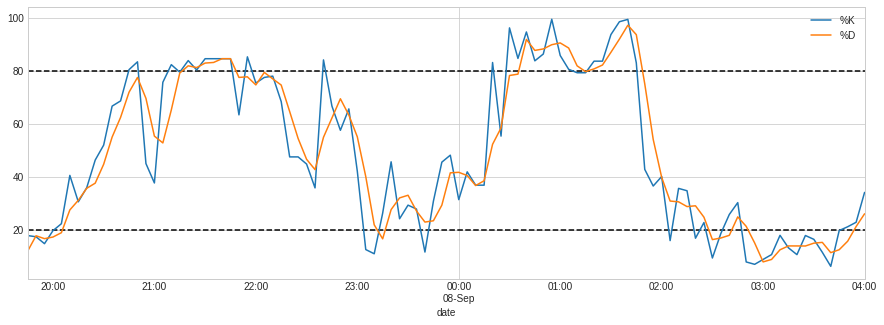

In [5]:
ax = data[['%K', '%D']].iloc[-100:].plot(figsize=(15,5))
plt.hlines(80, xmin=data.iloc[-100:].index[0], xmax=data.iloc[-100:].index[-1], colors='k', linestyles='--')
plt.hlines(20, xmin=data.iloc[-100:].index[0], xmax=data.iloc[-100:].index[-1], colors='k', linestyles='--')

In [6]:
# data['stoch_signal'] = np.where(data['%K'] > data['%D'], 1, np.where(data['%K'] < data['%D'], -1 ,0))
data['stoch_signal'] = np.where(data['%D'] > 80, -1,
                               np.where(data['%D'] < 20, 1, np.nan))
data['stoch_signal'].ffill(inplace=True)
print('Positions')
print(data['stoch_signal'].value_counts())
print('-'*50)
print('Positions change')
print(data['stoch_signal'].diff().apply(np.abs).value_counts())
print('-'*50)

Positions
-1.0    5212
 1.0    4773
Name: stoch_signal, dtype: int64
--------------------------------------------------
Positions change
0.0    9619
2.0     365
Name: stoch_signal, dtype: int64
--------------------------------------------------


In [7]:
backtest = IterativeBacktester(data, data['stoch_signal'], 'm5')

In [8]:
backtest.backtest()

  0%|          | 0/9984 [00:00<?, ?it/s]

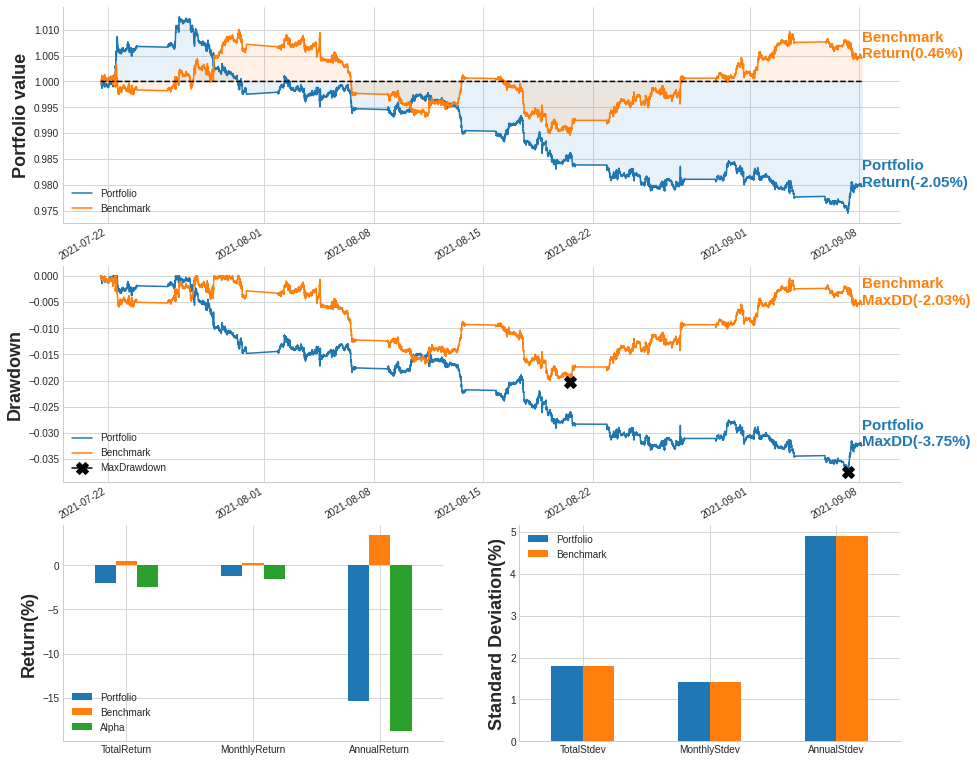

----------------------------------------------------------------------
Data length: |48 days 14:10:00|
Data range from |2021-07-21 13:50:00| to |2021-09-08 04:00:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │      -2.052 │       0.455 │  -2.507 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │      -1.267 │       0.281 │  -1.548 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │     -15.414 │       3.421 │ -18.835 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │   

In [9]:
backtest.results()